# Baseline Model - Class Weights Example
## Plant Disease Image Classification - Corn Crop Leaves
MSDS 634 Deep Learning Final Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

## Load Preprocessed Dataset

In [3]:
# Load the numpy files
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/train_data.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/val_data.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/val_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Let's display a sample image as a sanity check to make sure we loaded the data properly:

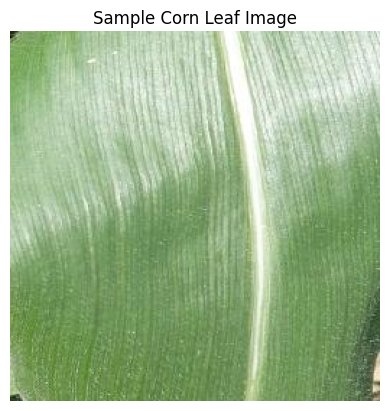

In [4]:
sample_image = train_data[10]

# Display the sample image
plt.imshow(sample_image.transpose(1, 2, 0))  # Transpose the dimensions for displaying with matplotlib
plt.title('Sample Corn Leaf Image')
plt.axis('off')  # Turn off axis
plt.show()


## Calculating Class Weights
To address the imbalanced data without having to oversampling/adding more images to our train dataset, we can use class weights and pass that into the loss function. See this article for more info: https://naadispeaks.blog/2021/07/31/handling-imbalanced-classes-with-weighted-loss-in-pytorch/

We'll calculate the class weights using the following formula:
$$ \text{class weight} = 1 - \frac{\text{number of samples of the class}}{\text{total number of samples}} $$

**Class weights don't have to sum to 1:** You might notice that the class weights below using the formula above don't sum to 1. The class weights used in the weight parameter of `CrossEntropyLoss()` in PyTorch do not need to sum to 1.
* The class weights are used to adjust the contribution of each class's loss to the overall loss during training. These weights are directly multiplied with the losses calculated for each class, effectively scaling the loss for each class according to the provided weights.
* Therefore, the class weights should reflect the relative importance or significance of each class in your dataset, but they do not need to sum to 1. The absolute values of the weights are what matter; their relative magnitudes determine the impact on the loss calculation.

In [10]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


Now we can pass in these class weights into the loss function to account for the class imbalance. Then we can run our training loop as usual!

In [11]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

## Baseline Model

Since this is a deep learning course, we'll be using a simple/shallow neural network with one hidden layer as our baseline model that will serve as a benchmark for the rest of our model experiments. Since this is a baseline model, there will be no special hyperparameter configuration and default values will be used.

**Note that we now added the class weights to the loss function below.**

In [12]:
# Define the shallow neural network model
class ShallowNN(nn.Module):
    def __init__(self):
        super(ShallowNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 256 * 256, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = ShallowNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float)) # ADDED CLASS WEIGHTS
optimizer = optim.Adam(model.parameters())

Let's now train the model:

In [13]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')


Epoch 1/10, Train Loss: 17.9482, Train F1 Score: 0.4986, Val Loss: 1.8884, Val F1 Score: 0.6737
Epoch 2/10, Train Loss: 1.3463, Train F1 Score: 0.7460, Val Loss: 0.7533, Val F1 Score: 0.7308
Epoch 3/10, Train Loss: 1.4754, Train F1 Score: 0.7608, Val Loss: 0.7996, Val F1 Score: 0.7696
Epoch 4/10, Train Loss: 1.0513, Train F1 Score: 0.8050, Val Loss: 2.3071, Val F1 Score: 0.7497
Epoch 5/10, Train Loss: 1.2818, Train F1 Score: 0.7927, Val Loss: 0.5999, Val F1 Score: 0.8256
Epoch 6/10, Train Loss: 0.5112, Train F1 Score: 0.8644, Val Loss: 0.4813, Val F1 Score: 0.8541
Epoch 7/10, Train Loss: 0.4122, Train F1 Score: 0.8698, Val Loss: 0.4264, Val F1 Score: 0.8352
Epoch 8/10, Train Loss: 0.4433, Train F1 Score: 0.8493, Val Loss: 1.2671, Val F1 Score: 0.7639
Epoch 9/10, Train Loss: 0.6444, Train F1 Score: 0.8246, Val Loss: 1.5078, Val F1 Score: 0.6461
Epoch 10/10, Train Loss: 0.7210, Train F1 Score: 0.8276, Val Loss: 0.4298, Val F1 Score: 0.8560
